<a href="https://colab.research.google.com/github/Tdas-christ/FraudShield/blob/main/FraudShield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a model that can be used for predicting fraudulent transactions for a financial company. Using the gained insights from the model, a strategy can be devised to minimize fraudulent activity. Data for the case is available in CSV format having 6362620 rows and 10 columns.

**Data Dictionary:**

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install imblearn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/DATASETS/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.isnull().sum() #There are no missing values present in the dataset

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [7]:
df.shape

(6362620, 11)

In [8]:
print(df.dtypes)

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [9]:
df = df.drop(columns=['step', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis = 1) #These attributes are not required moving forward

In [10]:
df.sample(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2135048,CASH_OUT,116152.51,0.00,0.00,4356705.56,4472858.07,0
5592352,CASH_OUT,106380.84,0.00,0.00,1266708.25,1373089.10,0
130971,PAYMENT,13893.65,0.00,0.00,0.00,0.00,0
1596339,PAYMENT,16634.86,30801.00,14166.14,0.00,0.00,0
1492860,CASH_OUT,156439.84,0.00,0.00,447653.62,604093.47,0
2516354,CASH_IN,241580.72,4468083.51,4709664.23,697272.79,455692.07,0
2011907,CASH_OUT,201170.65,17803.00,0.00,0.00,201170.65,0
6115160,CASH_IN,238190.81,3534698.07,3772888.88,5151038.77,4912847.96,0
779305,CASH_OUT,132238.26,56611.00,0.00,16154.25,148392.51,0
3486485,CASH_IN,333691.85,6287928.24,6621620.09,539260.08,205568.23,0


In [11]:
df.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [12]:
df['isFraud'].value_counts() #Checking if there is a class imbalance in the target variable

,count
isFraud,
0,6354407
1,8213


<Axes: xlabel='isFraud', ylabel='newbalanceDest'>

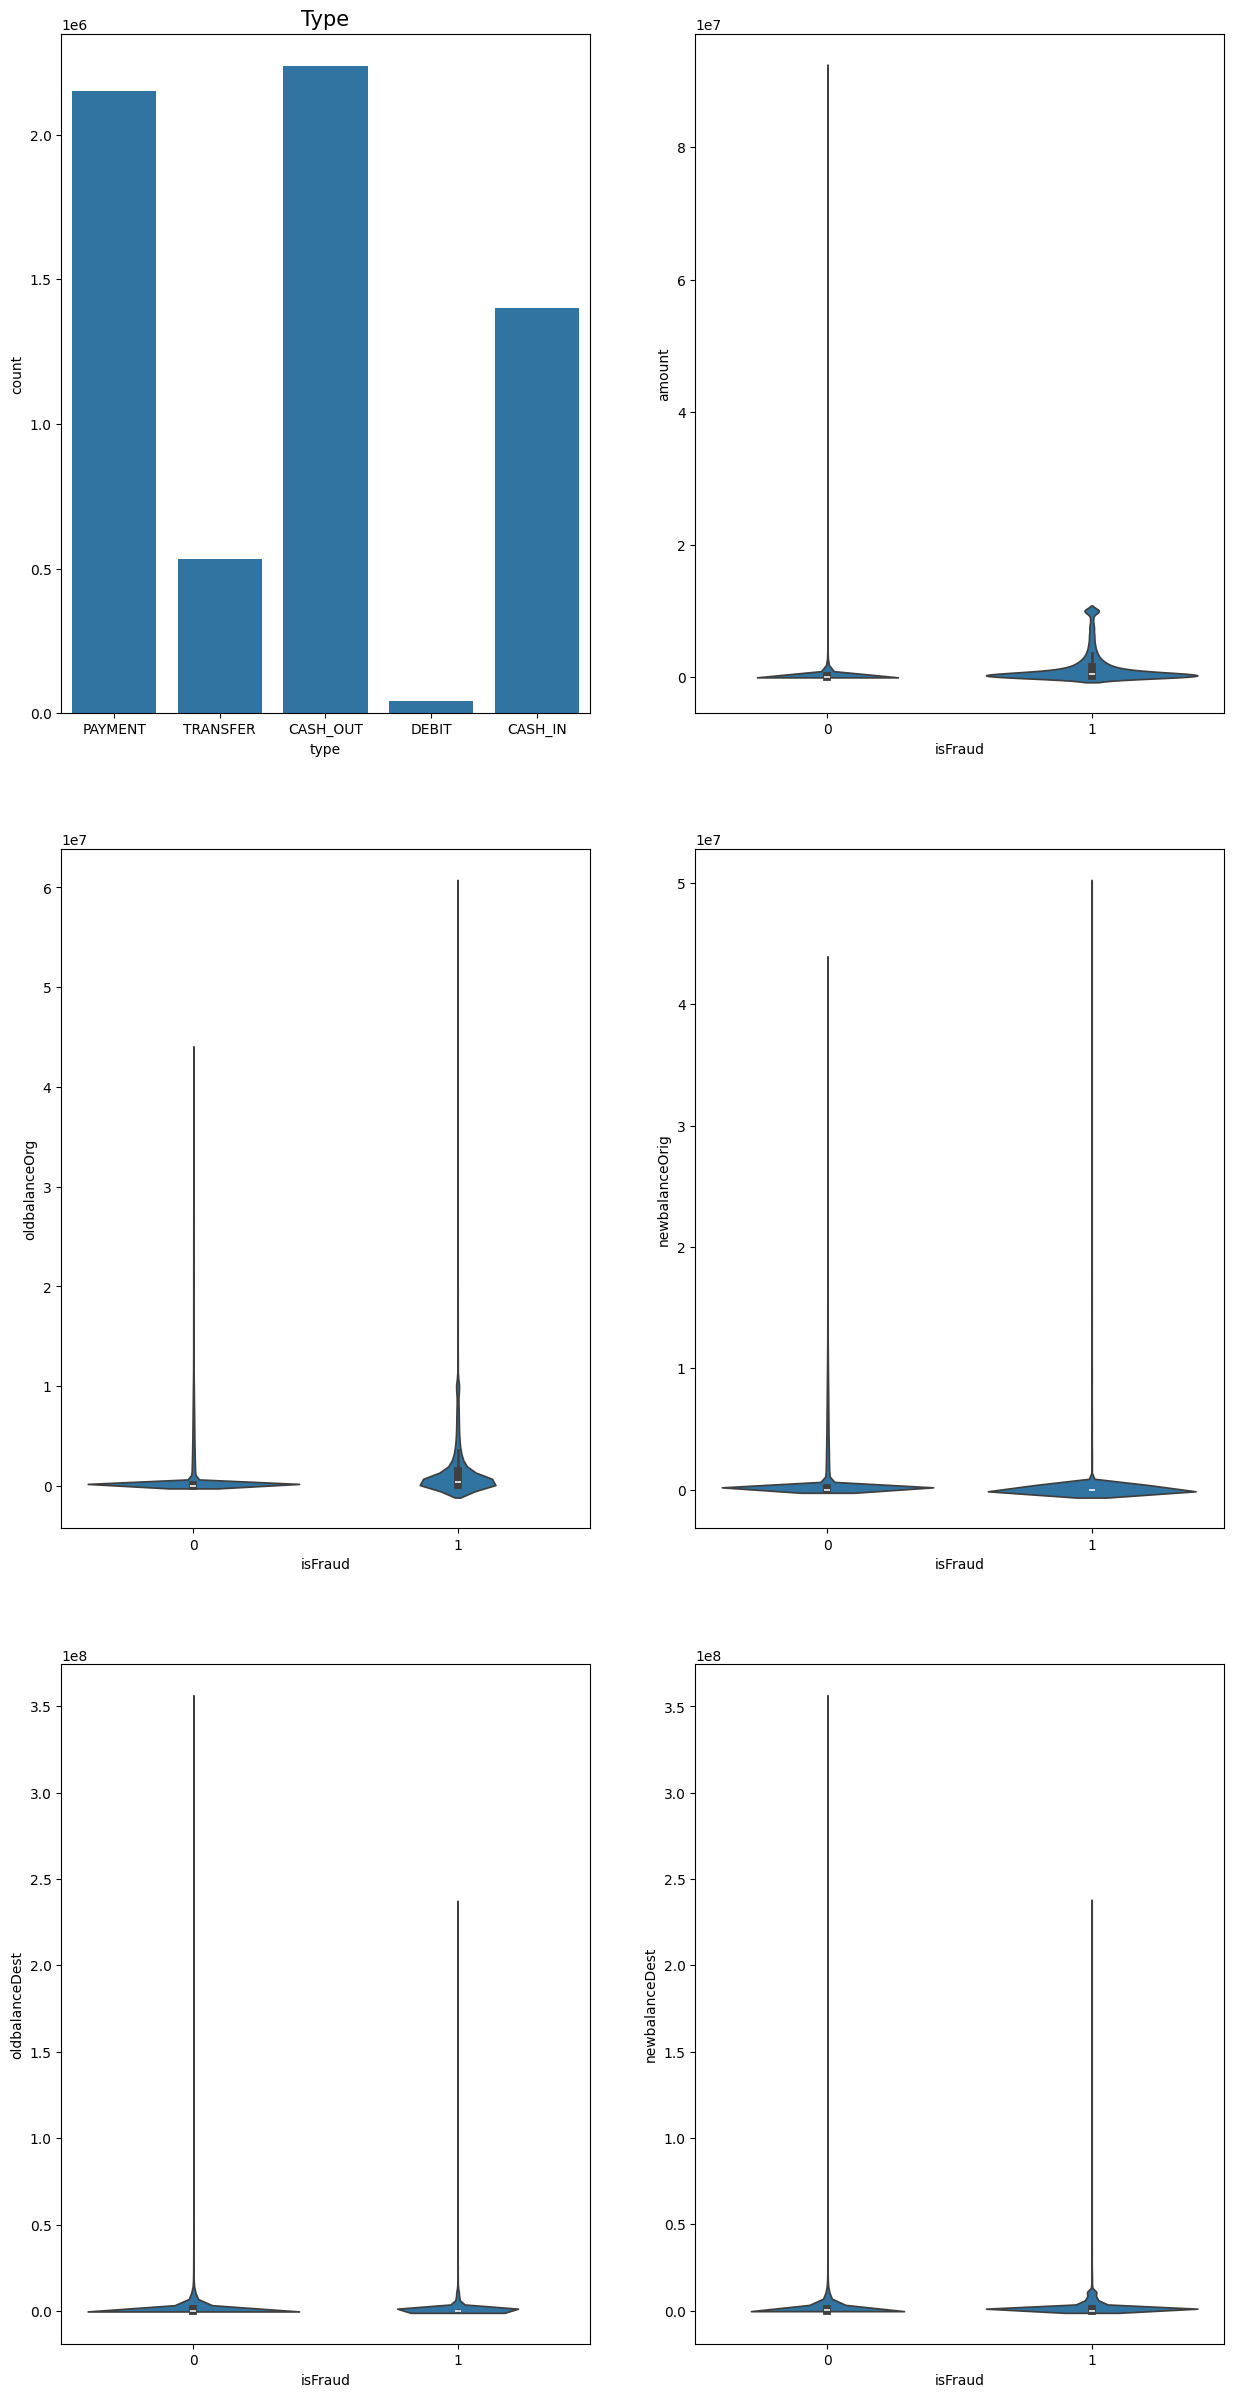

In [13]:
fig,ax=plt.subplots(3,2,figsize=(15,30))
sns.countplot(x=df.type,ax=ax[0][0]).set_title('Type',size=15)
sns.violinplot(x=df.isFraud,y=df['amount'],ax=ax[0][1])
sns.violinplot(x=df.isFraud,y=df['oldbalanceOrg'],ax=ax[1][0])
sns.violinplot(x=df.isFraud,y=df['newbalanceOrig'],ax=ax[1][1])
sns.violinplot(x=df.isFraud,y=df['oldbalanceDest'],ax=ax[2][0])
sns.violinplot(x=df.isFraud,y=df['newbalanceDest'],ax=ax[2][1])

We can clearly say there is a class imbalance.

## **Prediction model using xgboost**

In [14]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type']) #Label Encoding attribute 'type' so that we can apply SMOTE

In [15]:
!pip install pycaret[full]

In [16]:
from pycaret.classification import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [17]:
from imblearn.over_sampling import SMOTE
#There is a lot of class imbalance, hence we are using SMOTE for upsampling

x = df.drop(columns = ['isFraud'], axis=1)
y = df['isFraud']

smote = SMOTE(random_state=42)
X, Y = smote.fit_resample(x, y)

In [18]:
print(Y.value_counts()) #class imbalance fixed

isFraud
0    6354407
1    6354407
Name: count, dtype: int64


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42) #Dividing the dataset into training and testing set in the ratio 70:30

In [20]:
setup_df = setup(data= X_train, target = Y_train,
                session_id=100, data_split_stratify=True,
                remove_outliers=True)

,Description,Value
0,Session id,100
1,Target,isFraud
2,Target type,Binary
3,Original data shape,"(8896169, 7)"
4,Transformed data shape,"(8584809, 7)"
5,Transformed train set shape,"(5915958, 7)"
6,Transformed test set shape,"(2668851, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [21]:
xgb = create_model("xgboost")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9982,0.9999,0.9987,0.9978,0.9983,0.9965,0.9965
1,0.9981,0.9999,0.9987,0.9976,0.9981,0.9963,0.9963
2,0.9982,0.9999,0.9988,0.9976,0.9982,0.9963,0.9963
3,0.9968,0.9985,0.9981,0.9955,0.9968,0.9936,0.9936
4,0.9982,0.9999,0.9988,0.9976,0.9982,0.9964,0.9964
5,0.9982,0.9999,0.9989,0.9976,0.9982,0.9965,0.9965
6,0.9981,0.9999,0.9987,0.9975,0.9981,0.9962,0.9962
7,0.9982,0.9999,0.9988,0.9976,0.9982,0.9963,0.9963
8,0.9982,0.9999,0.9988,0.9976,0.9982,0.9965,0.9965


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

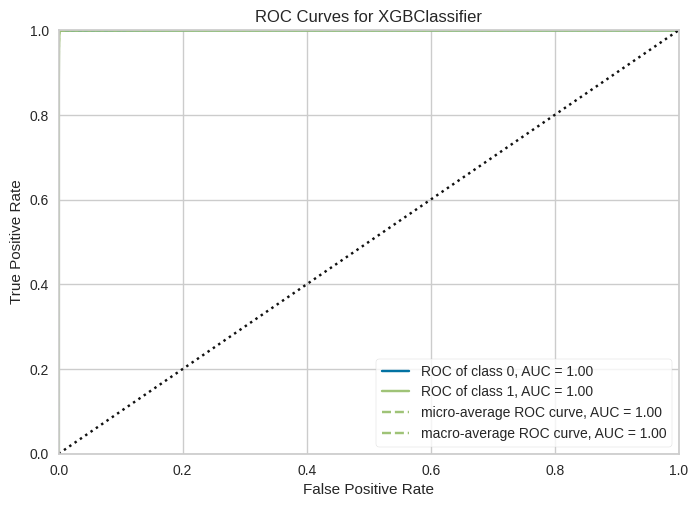

In [22]:
plot_model(estimator = xgb , plot= "auc")

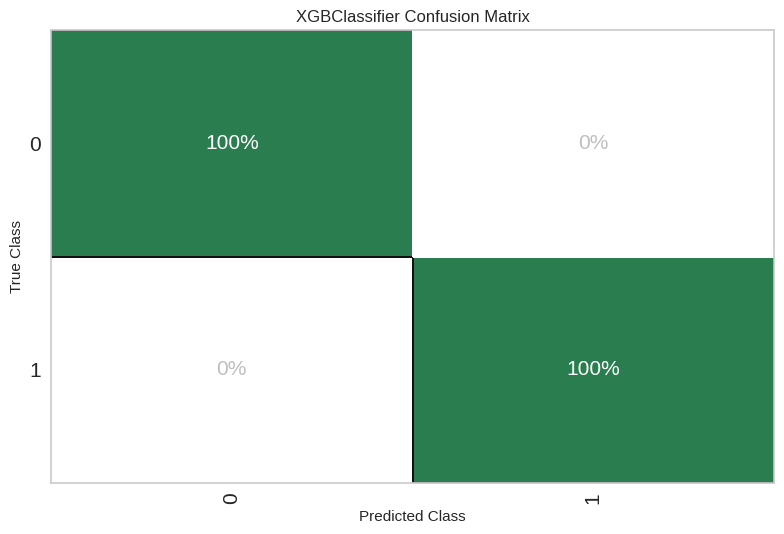

In [23]:
plot_model(estimator = xgb , plot= "confusion_matrix", plot_kwargs = {'percent' : True})

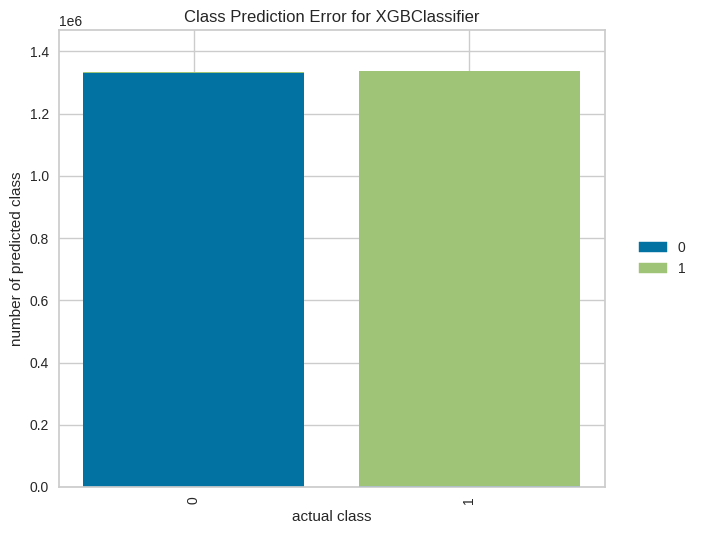

In [24]:
plot_model(estimator = xgb, plot = "error")

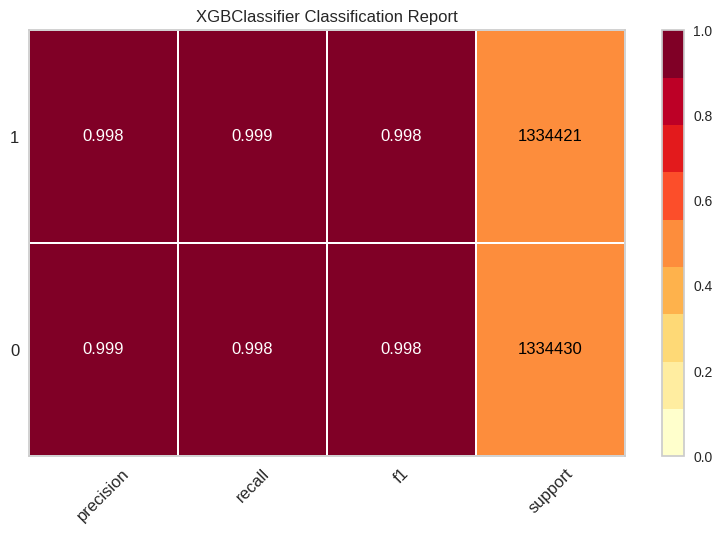

In [25]:
plot_model(estimator = xgb, plot = "class_report")

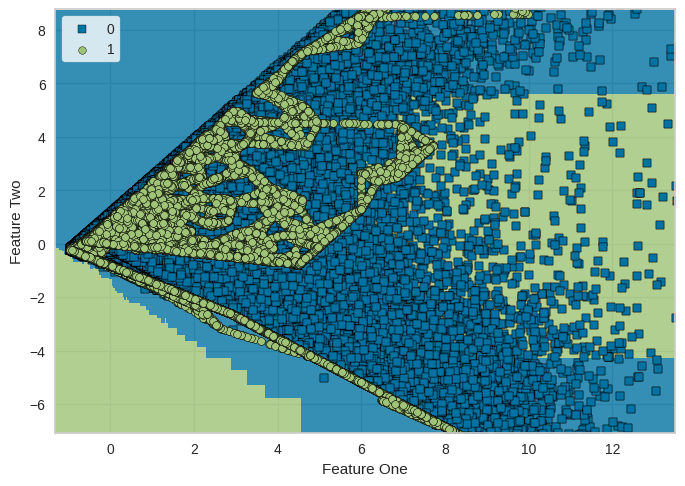

In [26]:
plot_model(estimator = xgb, plot = "boundary")

In [27]:
#interpret_model(xgb)

In [28]:
#predict_model(xgb)

In [30]:
#pred = predict_model(xgb, data=X_test)
#pred.head()

In [31]:
#accuracy_score(pred['isFraud'], pred['Label'])

## **Prediction model using Neural Networks**

In [32]:
#scaling the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# Define a more complex MLP model architecture
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),  # Adding dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),  # Adding another dropout layer
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])


In [34]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
# Train the model
history = model.fit(X_train_scaled, Y_train, epochs=3, batch_size=32, validation_split=0.2)

Epoch 1/3
222405/222405 ━━━━━━━━━━━━━━━━━━━━ 518s 2ms/step - accuracy: 0.9628 - loss: 0.0932 - val_accuracy: 0.9836 - val_loss: 0.0546
Epoch 2/3
222405/222405 ━━━━━━━━━━━━━━━━━━━━ 549s 2ms/step - accuracy: 0.9774 - loss: 0.0629 - val_accuracy: 0.9841 - val_loss: 0.0493
Epoch 3/3
222405/222405 ━━━━━━━━━━━━━━━━━━━━ 555s 2ms/step - accuracy: 0.9801 - loss: 0.0567 - val_accuracy: 0.9851 - val_loss: 0.0447


In [36]:
# Evaluate the model on the test set
Y_pred = model.predict(X_test_scaled)
Y_pred_binary = (Y_pred > 0.5).astype(int)

119146/119146 ━━━━━━━━━━━━━━━━━━━━ 158s 1ms/step


In [ ]:
# Evaluation metrics
accuracy = accuracy_score(Y_test, Y_pred_binary)
precision = precision_score(Y_test, Y_pred_binary)
recall = recall_score(Y_test, Y_pred_binary)
f1 = f1_score(Y_test, Y_pred_binary)
roc_auc = roc_auc_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred_binary)

In [38]:
#Printing the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9850888294084553
Precision: 0.9773655403037097
Recall: 0.9931785372568109
F1 Score: 0.9852085916147069
ROC AUC Score: 0.9984959245207962
Confusion Matrix:
 [[1862462   43847]
 [  13004 1893332]]


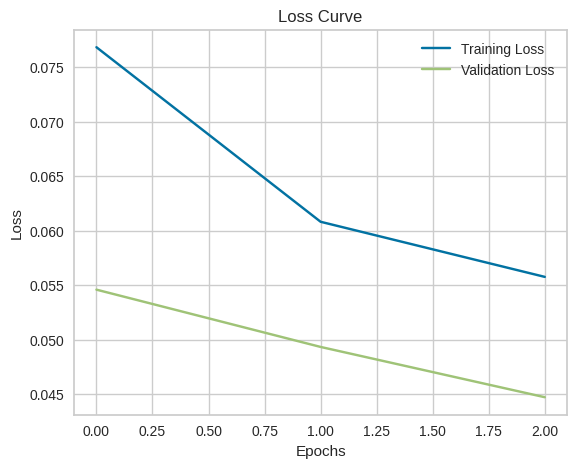

In [39]:
# Plotting the Loss and Accuracy curves
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

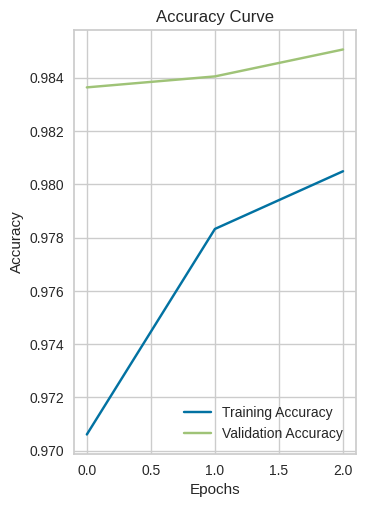

In [40]:
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

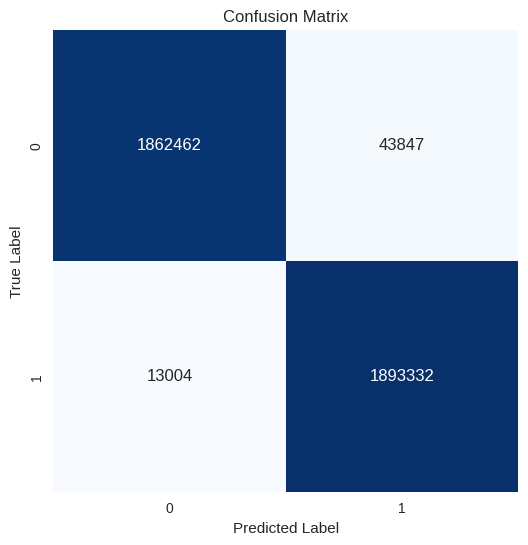

In [41]:
# Plotting the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

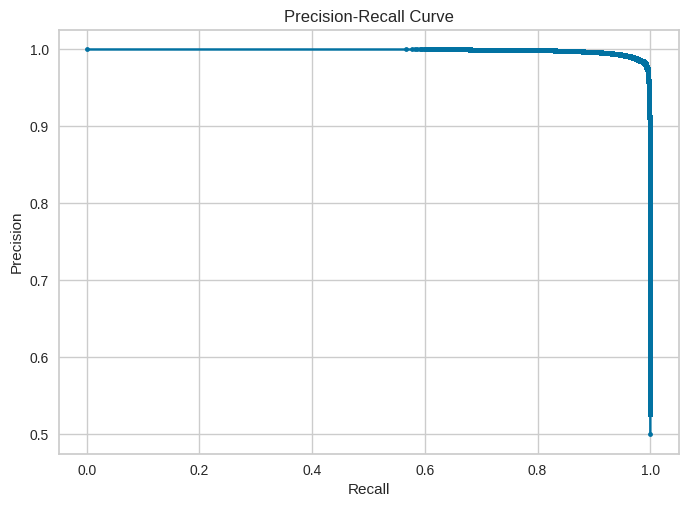

In [42]:
# Plotting the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test, Y_pred)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

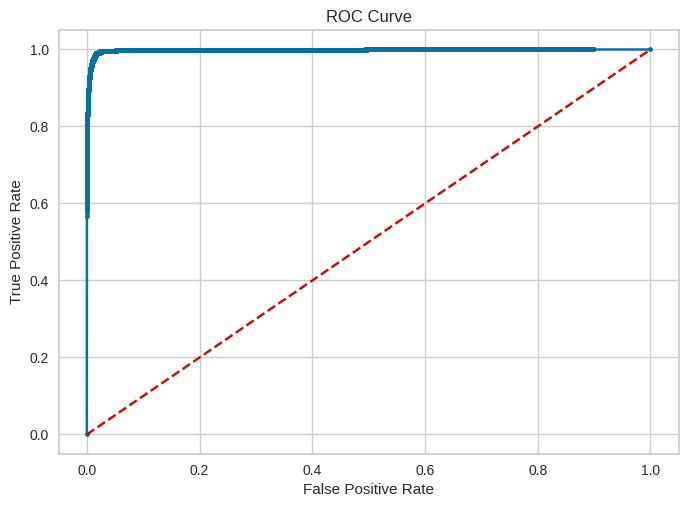

In [43]:
# Plotting the ROC Curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()